In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import copy
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

Using device: cuda:0


In [2]:
# Define transformations for training data (with augmentation)
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# Define transformations for testing data (no augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# Load CIFAR-100 dataset (automatically downloads if not present)
trainset = torchvision.datasets.CIFAR100(root='./content/drive/MyDrive/cifar-10-batches-py', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./content/drive/MyDrive/cifar-10-batches-py', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

# Get class names
classes = trainset.classes

# Print dataset information
print(f"Training set size: {len(trainset)}")
print(f"Test set size: {len(testset)}")
print(f"Number of classes: {len(classes)}")
print(f"Image dimensions: {trainset[0][0].shape}")

100%|██████████| 169M/169M [00:03<00:00, 48.7MB/s]


Training set size: 50000
Test set size: 10000
Number of classes: 100
Image dimensions: torch.Size([3, 32, 32])


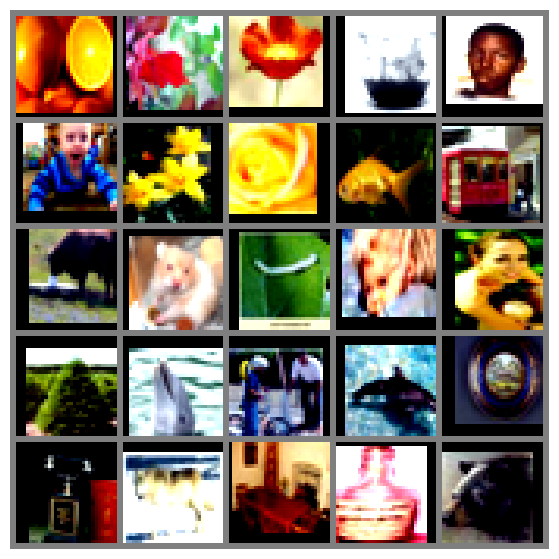

Labels:
      orange,         rose,        poppy,         bowl,          boy
        baby,        tulip,         rose, aquarium_fish,    streetcar
      cattle,      hamster,  caterpillar,         girl,        woman
   pine_tree,      dolphin,      bicycle,      dolphin,        plate
   telephone,         wolf,        table,       bottle,         bear


In [4]:
# Function to display images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15, 7))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Get random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:25], nrow=5))

# Print labels
print('Labels:')
for i in range(5):
    print(', '.join('%12s' % classes[labels[j]] for j in range(i*5, (i+1)*5)))

In [5]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # First Convolutional Block
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        # Second Convolutional Block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        # Third Convolutional Block
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.25)

        # Global Average Pooling and Classifier
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(256, 512)
        self.bn7 = nn.BatchNorm1d(512)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 100)  # 100 classes for CIFAR-100

        # Store filters for visualization
        self.first_layer_filters_before = None
        self.first_layer_filters_after = None

    def forward(self, x):
        # Save initial filters if not already saved
        if self.first_layer_filters_before is None and self.training:
            self.first_layer_filters_before = self.conv1.weight.data.clone()

        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Block 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        # Global Average Pooling and Classifier
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        x = self.fc2(x)

        # Save final filters after training is complete
        if not self.training and self.first_layer_filters_after is None:
            self.first_layer_filters_after = self.conv1.weight.data.clone()

        return x

    def get_filters(self):
        return self.first_layer_filters_before, self.first_layer_filters_after

In [6]:
def train_model(model, model_name, criterion, optimizer, scheduler, num_epochs=50, early_stopping=5):
    """Train a model and evaluate it on the validation set"""
    # Initialize variables
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    no_improve_epochs = 0

    # Lists to store metrics
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    # Move model to device
    model.to(device)

    # Start timing
    start_time = time.time()

    # Training loop
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = trainloader
            else:
                model.eval()
                dataloader = testloader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only during training
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Calculate epoch metrics
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.float() / len(dataloader.dataset)

            # Print epoch results
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store metrics for plotting
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())

                # Step scheduler based on train loss if needed
                if scheduler is not None and isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(epoch_loss)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())

                # Step scheduler based on validation metrics
                if scheduler is not None and not isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step()

                # Save best model
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    no_improve_epochs = 0
                else:
                    no_improve_epochs += 1

        # Early stopping
        if no_improve_epochs >= early_stopping:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

        print()

    # Training complete
    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Save the model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None,
        'best_acc': best_acc,
    }, f'{model_name}_cifar100.pth')

    return model, train_losses, val_losses, train_accs, val_accs

def evaluate_model(model, dataloader):
    """Calculate detailed classification metrics for model evaluation"""
    # Set model to evaluation mode
    model.eval()
    model.to(device)

    # Initialize variables
    all_preds = []
    all_labels = []

    # No gradient tracking needed for evaluation
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Store predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Calculate metrics
    accuracy = np.sum(all_preds == all_labels) / len(all_labels)

    # Calculate per-class metrics
    tp = np.zeros(100)
    fp = np.zeros(100)
    fn = np.zeros(100)
    tn = np.zeros(100)

    for i in range(100):
        tp[i] = cm[i, i]
        fp[i] = np.sum(cm[:, i]) - tp[i]
        fn[i] = np.sum(cm[i, :]) - tp[i]
        tn[i] = np.sum(cm) - tp[i] - fp[i] - fn[i]

    # Calculate precision, recall, F1-score
    with np.errstate(divide='ignore', invalid='ignore'):  # Handle division by zero
        precision = np.nan_to_num(tp / (tp + fp))
        recall = np.nan_to_num(tp / (tp + fn))
        f1 = np.nan_to_num(2 * precision * recall / (precision + recall))

    # Calculate averages
    avg_precision = np.mean(precision)
    avg_recall = np.mean(recall)
    avg_f1 = np.mean(f1)

    # Sum TP, FP, FN, TN
    sum_tp = np.sum(tp)
    sum_fp = np.sum(fp)
    sum_fn = np.sum(fn)
    sum_tn = np.sum(tn)

    # Return metrics
    return {
        "accuracy": accuracy,
        "precision": avg_precision,
        "recall": avg_recall,
        "f1_score": avg_f1,
        "true_positives": sum_tp,
        "false_positives": sum_fp,
        "false_negatives": sum_fn,
        "true_negatives": sum_tn,
        "confusion_matrix": cm
    }

In [11]:
def plot_training_history(train_losses, val_losses, train_accs, val_accs, title):
    """Plot training history with loss and accuracy"""
    plt.figure(figsize=(15, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{title} - Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{title}_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

def visualize_filters(model, title):
    """Visualize first layer filters before and after training"""
    # For custom model with saved filters
    if hasattr(model, 'get_filters'):
        before_filters, after_filters = model.get_filters()

        if before_filters is not None and after_filters is not None:
            plt.figure(figsize=(20, 8))
            grid_size = 8
            max_filters = grid_size * 2  # Total filters to display (16)

            # Plot before filters on top row
            for i in range(min(grid_size, before_filters.size(0))):
                plt.subplot(2, grid_size, i+1)  # Position in first row
                filter_viz = before_filters[i, 0, :, :].detach().cpu().numpy()
                # Normalize filter for visualization
                filter_viz = (filter_viz - filter_viz.min()) / (filter_viz.max() - filter_viz.min() + 1e-8)
                plt.imshow(filter_viz, cmap='viridis')
                plt.axis('off')
                if i == 0:
                    plt.title("Before Training", fontsize=10)

            # Plot after filters on bottom row
            for i in range(min(grid_size, after_filters.size(0))):
                plt.subplot(2, grid_size, i+grid_size+1)  # Position in second row
                filter_viz = after_filters[i, 0, :, :].detach().cpu().numpy()
                # Normalize filter for visualization
                filter_viz = (filter_viz - filter_viz.min()) / (filter_viz.max() - filter_viz.min() + 1e-8)
                plt.imshow(filter_viz, cmap='viridis')
                plt.axis('off')
                if i == 0:
                    plt.title("After Training", fontsize=10)

            plt.suptitle(f"{title} - First Layer Filters Before and After Training")
            plt.tight_layout()
            plt.savefig(f'{title}_filters.png', dpi=300, bbox_inches='tight')
            plt.show()

    # For standard models
    elif hasattr(model, 'conv1'):
        filters = model.conv1.weight.data

        plt.figure(figsize=(12, 6))
        plt.suptitle(f"{title} - First Layer Filters")
        grid_size = 8
        n_rows = (min(filters.size(0), grid_size*2) + grid_size - 1) // grid_size

        for i in range(min(grid_size * n_rows, filters.size(0))):
            plt.subplot(n_rows, grid_size, i+1)
            filter_viz = filters[i, 0, :, :].detach().cpu().numpy()
            # Normalize filter for visualization
            filter_viz = (filter_viz - filter_viz.min()) / (filter_viz.max() - filter_viz.min() + 1e-8)
            plt.imshow(filter_viz, cmap='viridis')
            plt.axis('off')

        plt.tight_layout()
        plt.savefig(f'{title}_filters.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print(f"Cannot visualize filters for {title} - incompatible model structure")

def plot_confusion_matrix(conf_matrix, title, n_classes=10):
    """Plot a subset of the confusion matrix (first n_classes)"""
    plt.figure(figsize=(10, 8))

    # Plot a subset for visibility (full 100x100 would be unreadable)
    subset_cm = conf_matrix[:n_classes, :n_classes]

    sns.heatmap(subset_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{title} - Confusion Matrix (First {n_classes} Classes)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'{title}_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Log accuracy statistics
    class_acc = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    print(f"Top 5 classes by accuracy:")
    top5_idx = np.argsort(class_acc)[-5:]
    for idx in reversed(top5_idx):
        print(f"  Class {idx}: {class_acc[idx]:.4f}")

    print(f"\nBottom 5 classes by accuracy:")
    bottom5_idx = np.argsort(class_acc)[:5]
    for idx in bottom5_idx:
        print(f"  Class {idx}: {class_acc[idx]:.4f}")

In [12]:
def setup_standard_models():
    """Create and configure standard CNN models for CIFAR-100"""
    models_dict = {}

    # 1. ResNet-50
    print("Setting up ResNet-50...")
    resnet50 = torchvision.models.resnet50(pretrained=False)
    # Adjust first layer for 32x32 input
    resnet50.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    # Remove maxpool to maintain spatial dimensions
    resnet50.maxpool = nn.Identity()
    # Adjust final fully connected layer for 100 classes
    resnet50.fc = nn.Linear(resnet50.fc.in_features, 100)
    models_dict['ResNet-50'] = resnet50

    # 2. VGG-19
    print("Setting up VGG-19...")
    vgg19 = torchvision.models.vgg19_bn(pretrained=False)
    # Adjust classifier for 100 classes
    vgg19.classifier[6] = nn.Linear(4096, 100)
    models_dict['VGG-19'] = vgg19

    # 3. DenseNet-121
    print("Setting up DenseNet-121...")
    densenet121 = torchvision.models.densenet121(pretrained=False)
    # Adjust classifier for 100 classes
    densenet121.classifier = nn.Linear(densenet121.classifier.in_features, 100)
    models_dict['DenseNet-121'] = densenet121

    # 4. EfficientNet-B0
    print("Setting up EfficientNet-B0...")
    efficientnet = torchvision.models.efficientnet_b0(pretrained=False)
    # Adjust classifier for 100 classes
    efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, 100)
    models_dict['EfficientNet-B0'] = efficientnet

    return models_dict

In [13]:
def compare_models(results):
    """Compare and visualize model performance metrics"""
    models = list(results.keys())

    # Extract metrics
    metrics = {
        'Accuracy': [results[m]['accuracy'] for m in models],
        'Precision': [results[m]['precision'] for m in models],
        'Recall': [results[m]['recall'] for m in models],
        'F1-Score': [results[m]['f1_score'] for m in models]
    }

    # Create DataFrame for table
    df = pd.DataFrame({
        'Model': models,
        'Accuracy': [f"{acc:.4f}" for acc in metrics['Accuracy']],
        'Precision': [f"{p:.4f}" for p in metrics['Precision']],
        'Recall': [f"{r:.4f}" for r in metrics['Recall']],
        'F1-Score': [f"{f1:.4f}" for f1 in metrics['F1-Score']],
        'TP': [int(results[m]['true_positives']) for m in models],
        'FP': [int(results[m]['false_positives']) for m in models],
        'FN': [int(results[m]['false_negatives']) for m in models]
    })

    # Display table
    display(df)

    # Create bar charts for comparison
    plt.figure(figsize=(14, 8))

    # Metrics
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    x = np.arange(len(models))
    width = 0.2

    # Plot bars for each metric
    for i, metric in enumerate(metric_names):
        plt.bar(x + i*width - 0.3, metrics[metric], width, label=metric)

    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, models, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Save results
    df.to_csv('model_comparison.csv', index=False)

    return df

Model architecture:
CustomCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv5): Conv2d(128, 256, kernel_size

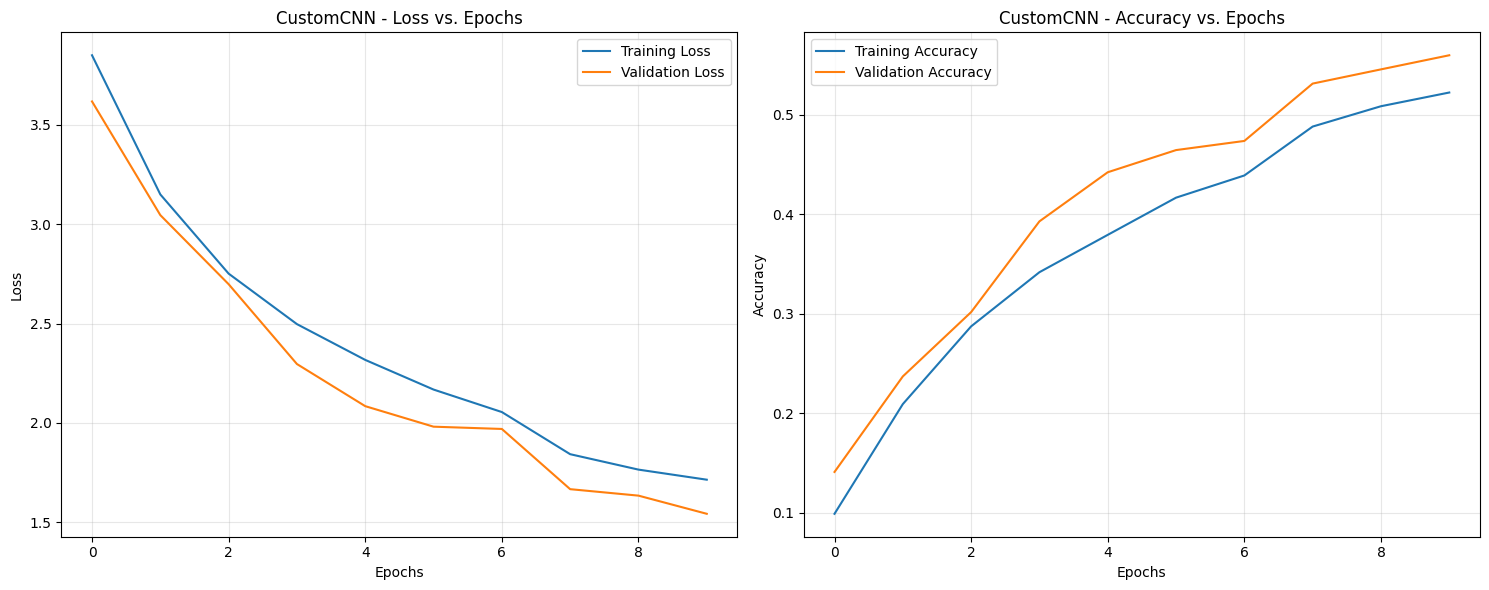

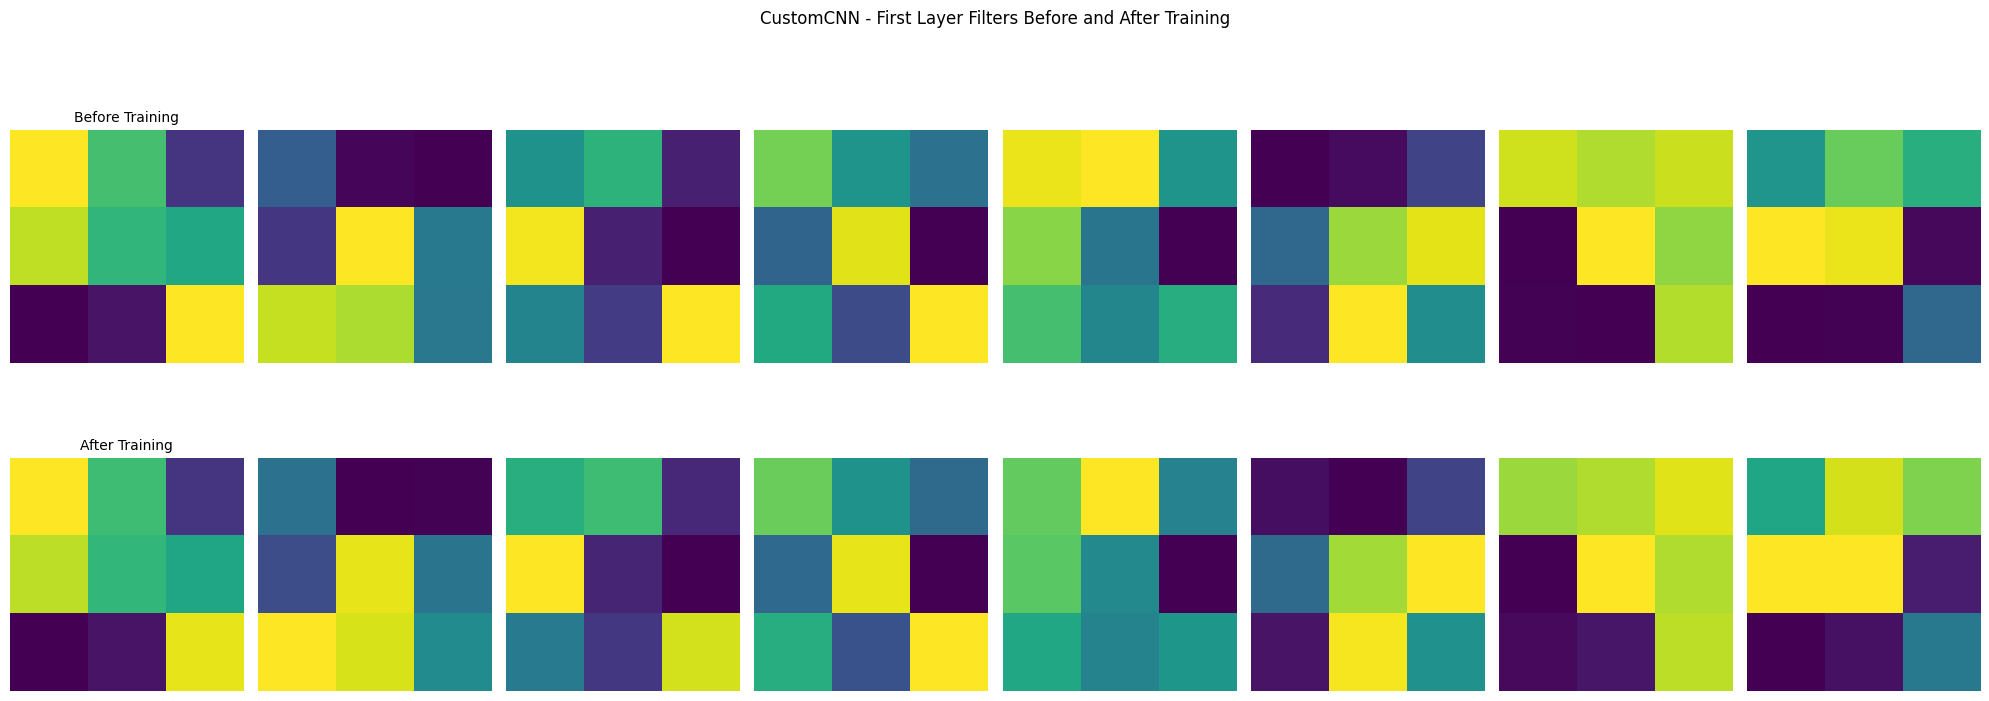


Evaluating Custom CNN...

Custom CNN Metrics:
Accuracy: 0.5600
Precision: 0.5660
Recall: 0.5600
F1-Score: 0.5520
True Positives: 5600.0
False Positives: 4400.0
False Negatives: 4400.0


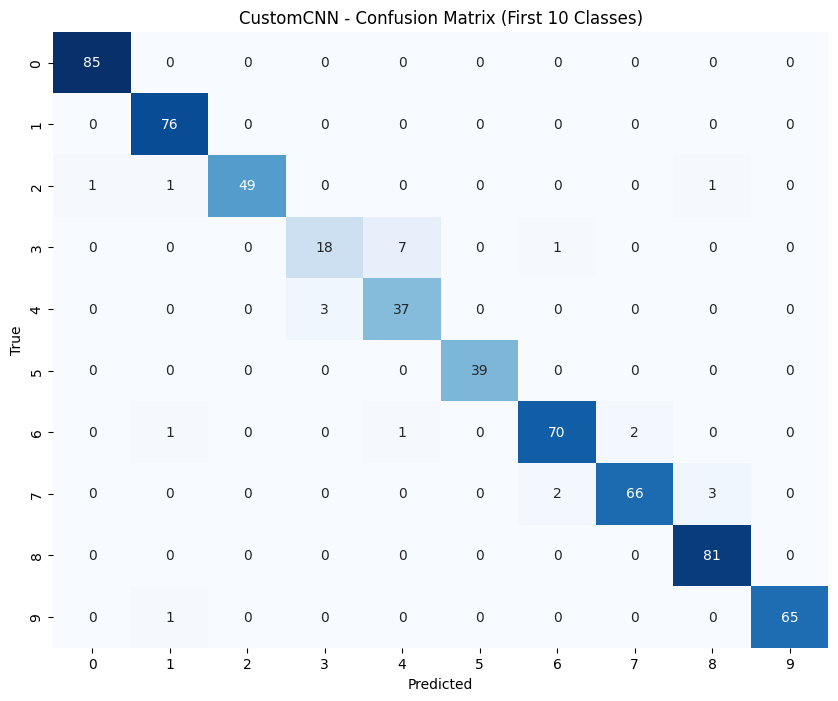

Top 5 classes by accuracy:
  Class 94: 0.9500
  Class 68: 0.8900
  Class 48: 0.8900
  Class 52: 0.8800
  Class 21: 0.8800

Bottom 5 classes by accuracy:
  Class 44: 0.1300
  Class 72: 0.1600
  Class 55: 0.1700
  Class 3: 0.1800
  Class 11: 0.1800


In [14]:
# Initialize Custom CNN
custom_model = CustomCNN()
print("Model architecture:")
print(custom_model)

# Define loss function, optimizer and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

# Train model
print("\nTraining Custom CNN...")
custom_model, train_losses, val_losses, train_accs, val_accs = train_model(
    custom_model, "CustomCNN", criterion, optimizer, scheduler, num_epochs=10, early_stopping=10)

# Plot training history
plot_training_history(train_losses, val_losses, train_accs, val_accs, "CustomCNN")

# Visualize filters
visualize_filters(custom_model, "CustomCNN")

# Evaluate model
print("\nEvaluating Custom CNN...")
custom_metrics = evaluate_model(custom_model, testloader)

# Print metrics
print("\nCustom CNN Metrics:")
print(f"Accuracy: {custom_metrics['accuracy']:.4f}")
print(f"Precision: {custom_metrics['precision']:.4f}")
print(f"Recall: {custom_metrics['recall']:.4f}")
print(f"F1-Score: {custom_metrics['f1_score']:.4f}")
print(f"True Positives: {custom_metrics['true_positives']}")
print(f"False Positives: {custom_metrics['false_positives']}")
print(f"False Negatives: {custom_metrics['false_negatives']}")

# Plot confusion matrix
plot_confusion_matrix(custom_metrics['confusion_matrix'], "CustomCNN")

# Store results for later comparison
results = {"CustomCNN": custom_metrics}

Setting up ResNet-50...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Setting up VGG-19...
Setting up DenseNet-121...
Setting up EfficientNet-B0...

===== Processing ResNet-50 =====
Epoch 1/10
----------


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


train Loss: 4.1168 Acc: 0.0730
val Loss: 3.6747 Acc: 0.1366

Epoch 2/10
----------
train Loss: 3.2993 Acc: 0.1881
val Loss: 3.1291 Acc: 0.2276

Epoch 3/10
----------
train Loss: 2.7288 Acc: 0.2947
val Loss: 2.7448 Acc: 0.3088

Epoch 4/10
----------
train Loss: 2.3272 Acc: 0.3782
val Loss: 2.3912 Acc: 0.3744

Epoch 5/10
----------
train Loss: 2.0686 Acc: 0.4387
val Loss: 2.0867 Acc: 0.4361

Epoch 6/10
----------
train Loss: 1.6846 Acc: 0.5264
val Loss: 1.7626 Acc: 0.5160

Epoch 7/10
----------
train Loss: 1.5465 Acc: 0.5612
val Loss: 1.6750 Acc: 0.5362

Epoch 8/10
----------
train Loss: 1.4422 Acc: 0.5868
val Loss: 1.5036 Acc: 0.5805

Epoch 9/10
----------
train Loss: 1.3563 Acc: 0.6092
val Loss: 1.5272 Acc: 0.5789

Epoch 10/10
----------
train Loss: 1.1146 Acc: 0.6681
val Loss: 1.3269 Acc: 0.6286

Training complete in 30m 55s
Best val Acc: 0.6286


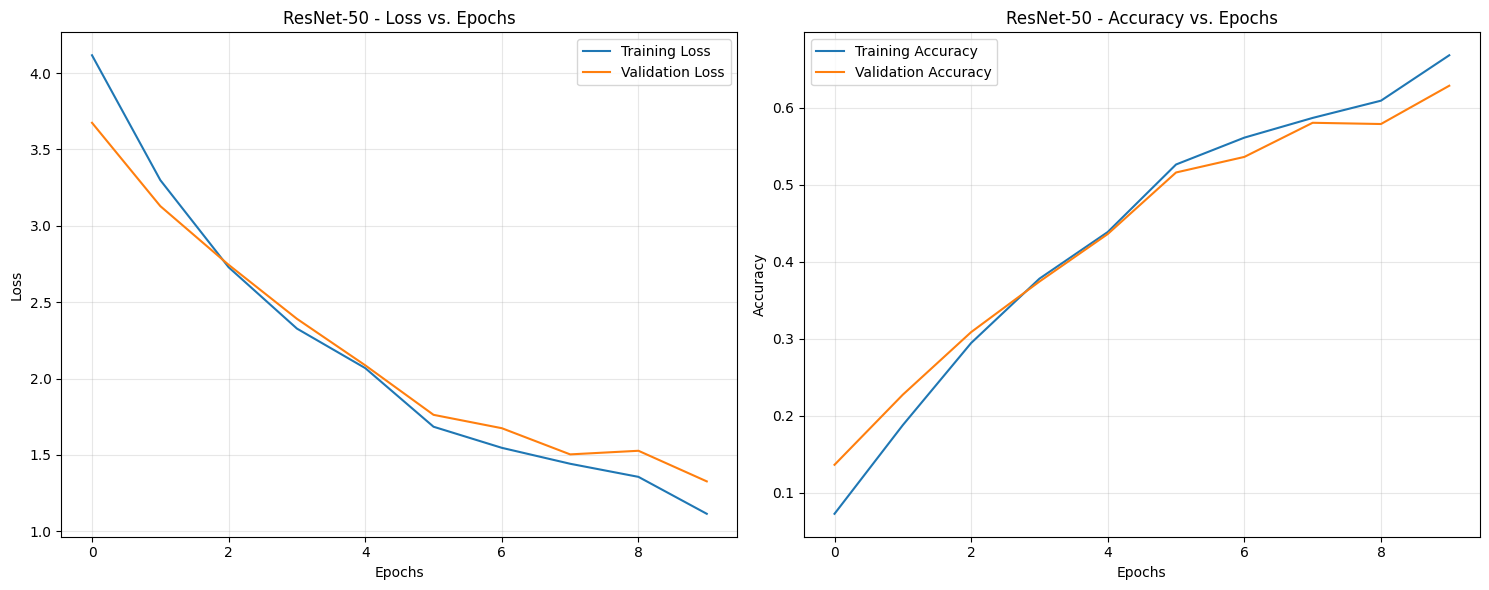


ResNet-50 Metrics:
Accuracy: 0.6286
Precision: 0.6510
Recall: 0.6286
F1-Score: 0.6275
True Positives: 6286.0
False Positives: 3714.0
False Negatives: 3714.0


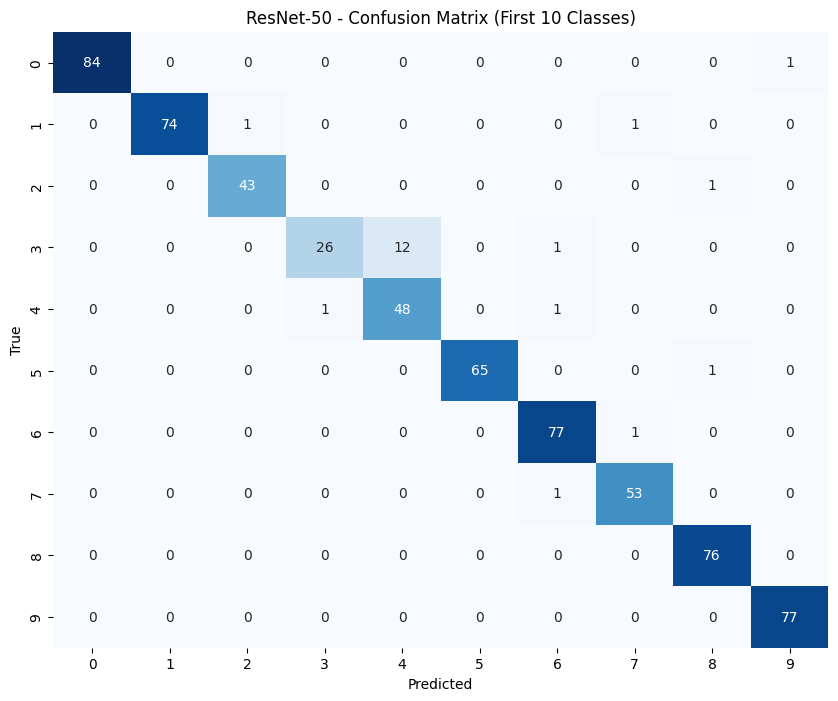

Top 5 classes by accuracy:
  Class 68: 0.9500
  Class 48: 0.9100
  Class 53: 0.9100
  Class 21: 0.9000
  Class 56: 0.8800

Bottom 5 classes by accuracy:
  Class 11: 0.1600
  Class 55: 0.2500
  Class 80: 0.2500
  Class 44: 0.2600
  Class 3: 0.2600

===== Processing VGG-19 =====


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/10
----------
train Loss: 5.0590 Acc: 0.0122
val Loss: 4.5963 Acc: 0.0142

Epoch 2/10
----------
train Loss: 4.6073 Acc: 0.0122
val Loss: 4.6101 Acc: 0.0097

Epoch 3/10
----------
train Loss: 4.5943 Acc: 0.0113
val Loss: 4.5471 Acc: 0.0172

Epoch 4/10
----------
train Loss: 4.5969 Acc: 0.0121
val Loss: 4.5420 Acc: 0.0181

Epoch 5/10
----------
train Loss: 4.5908 Acc: 0.0121
val Loss: 4.5324 Acc: 0.0135

Epoch 6/10
----------
train Loss: 4.5939 Acc: 0.0110
val Loss: 4.5430 Acc: 0.0126

Epoch 7/10
----------
train Loss: 4.5439 Acc: 0.0134
val Loss: 4.4571 Acc: 0.0174

Epoch 8/10
----------
train Loss: 4.4941 Acc: 0.0173
val Loss: 4.4859 Acc: 0.0213

Epoch 9/10
----------
train Loss: 4.4591 Acc: 0.0184
val Loss: 4.5040 Acc: 0.0164

Epoch 10/10
----------
train Loss: 4.4072 Acc: 0.0208
val Loss: 4.3909 Acc: 0.0271

Training complete in 9m 47s
Best val Acc: 0.0271


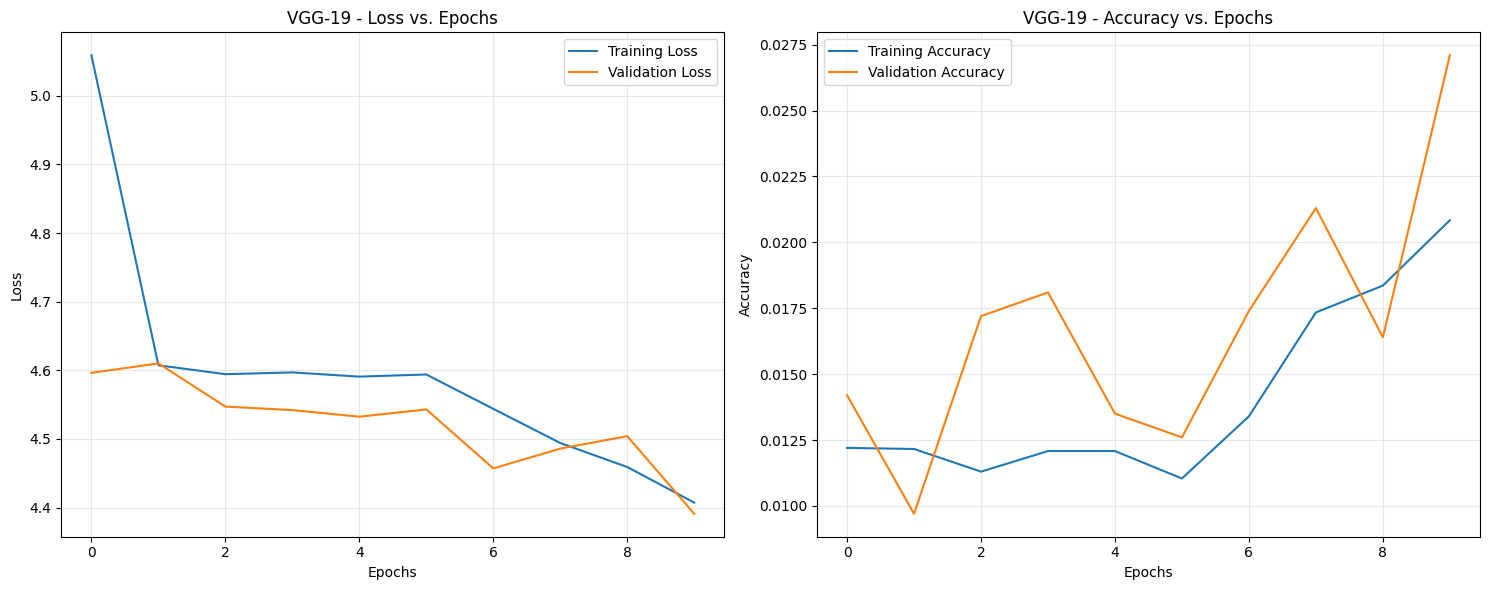


VGG-19 Metrics:
Accuracy: 0.0271
Precision: 0.0021
Recall: 0.0271
F1-Score: 0.0034
True Positives: 271.0
False Positives: 9729.0
False Negatives: 9729.0


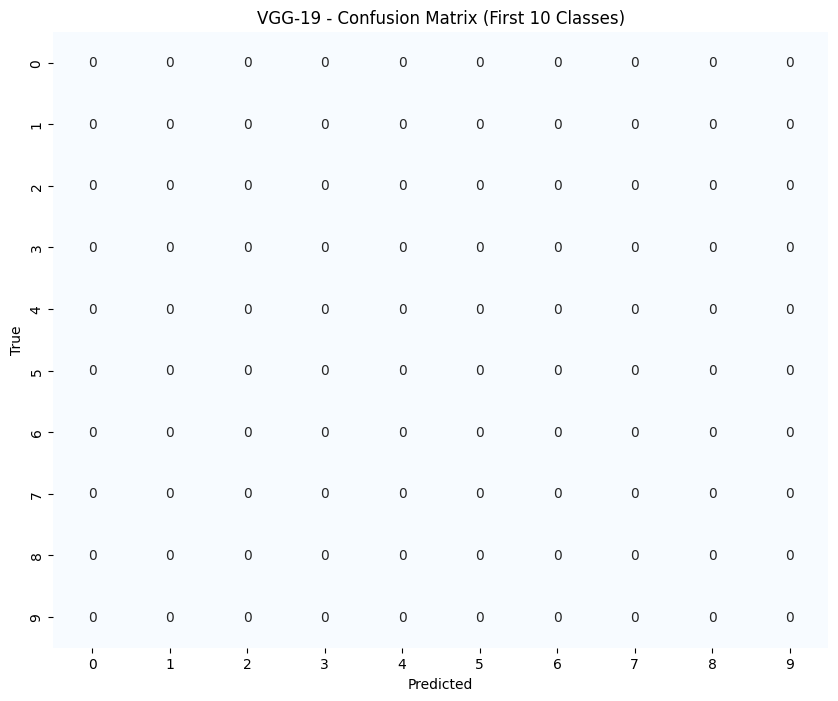

Top 5 classes by accuracy:
  Class 53: 0.9900
  Class 23: 0.7100
  Class 21: 0.4000
  Class 52: 0.3800
  Class 24: 0.1700

Bottom 5 classes by accuracy:
  Class 0: 0.0000
  Class 1: 0.0000
  Class 2: 0.0000
  Class 3: 0.0000
  Class 4: 0.0000

===== Processing DenseNet-121 =====
Epoch 1/10
----------


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


train Loss: 3.7885 Acc: 0.1194
val Loss: 3.4131 Acc: 0.1784

Epoch 2/10
----------
train Loss: 3.1136 Acc: 0.2269
val Loss: 2.8834 Acc: 0.2697

Epoch 3/10
----------
train Loss: 2.7529 Acc: 0.2965
val Loss: 2.6442 Acc: 0.3314

Epoch 4/10
----------
train Loss: 2.5023 Acc: 0.3463
val Loss: 2.4650 Acc: 0.3597

Epoch 5/10
----------
train Loss: 2.3039 Acc: 0.3883
val Loss: 2.2695 Acc: 0.4037

Epoch 6/10
----------
train Loss: 1.9950 Acc: 0.4594
val Loss: 2.0098 Acc: 0.4645

Epoch 7/10
----------
train Loss: 1.8772 Acc: 0.4851
val Loss: 1.9564 Acc: 0.4798

Epoch 8/10
----------
train Loss: 1.7822 Acc: 0.5074
val Loss: 1.9292 Acc: 0.4868

Epoch 9/10
----------
train Loss: 1.6915 Acc: 0.5270
val Loss: 1.8871 Acc: 0.4948

Epoch 10/10
----------
train Loss: 1.4924 Acc: 0.5799
val Loss: 1.7419 Acc: 0.5276

Training complete in 9m 42s
Best val Acc: 0.5276


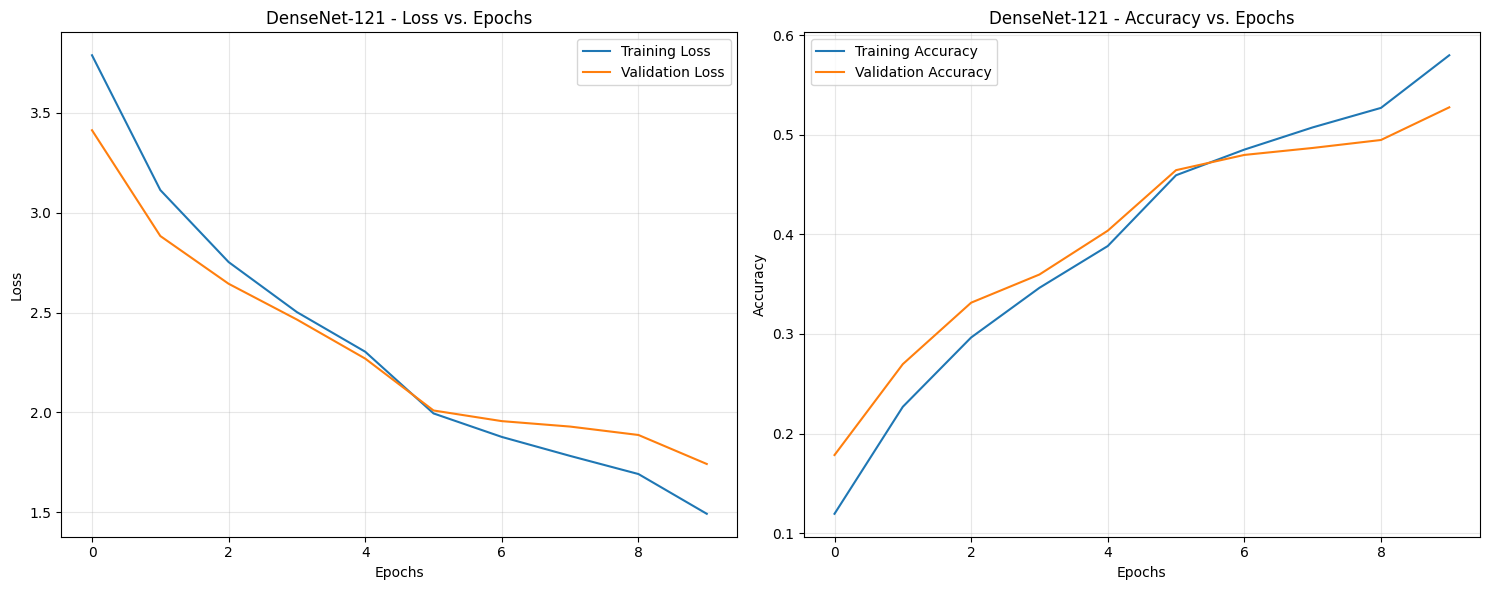


DenseNet-121 Metrics:
Accuracy: 0.5276
Precision: 0.5288
Recall: 0.5276
F1-Score: 0.5208
True Positives: 5276.0
False Positives: 4724.0
False Negatives: 4724.0


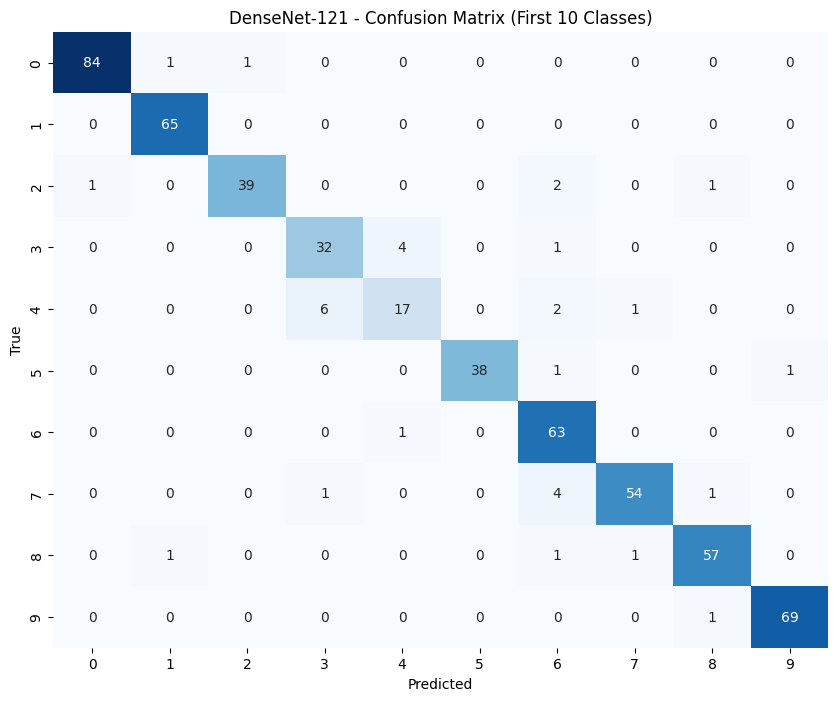

Top 5 classes by accuracy:
  Class 75: 0.8700
  Class 0: 0.8400
  Class 94: 0.8300
  Class 60: 0.8200
  Class 48: 0.8200

Bottom 5 classes by accuracy:
  Class 4: 0.1700
  Class 55: 0.1800
  Class 72: 0.1800
  Class 11: 0.2100
  Class 44: 0.2200

===== Processing EfficientNet-B0 =====
Epoch 1/10
----------


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


train Loss: 4.3516 Acc: 0.0376
val Loss: 4.0390 Acc: 0.0766

Epoch 2/10
----------
train Loss: 3.9502 Acc: 0.0845
val Loss: 3.7154 Acc: 0.1049

Epoch 3/10
----------
train Loss: 3.7135 Acc: 0.1189
val Loss: 3.5320 Acc: 0.1539

Epoch 4/10
----------
train Loss: 3.5120 Acc: 0.1518
val Loss: 3.2852 Acc: 0.2032

Epoch 5/10
----------
train Loss: 3.3202 Acc: 0.1858
val Loss: 3.1563 Acc: 0.2270

Epoch 6/10
----------
train Loss: 3.1006 Acc: 0.2245
val Loss: 2.9562 Acc: 0.2573

Epoch 7/10
----------
train Loss: 2.9994 Acc: 0.2458
val Loss: 2.8662 Acc: 0.2795

Epoch 8/10
----------
train Loss: 2.9198 Acc: 0.2595
val Loss: 2.7695 Acc: 0.2937

Epoch 9/10
----------
train Loss: 2.8303 Acc: 0.2765
val Loss: 2.7350 Acc: 0.3010

Epoch 10/10
----------
train Loss: 2.6966 Acc: 0.3054
val Loss: 2.5804 Acc: 0.3352

Training complete in 7m 28s
Best val Acc: 0.3352


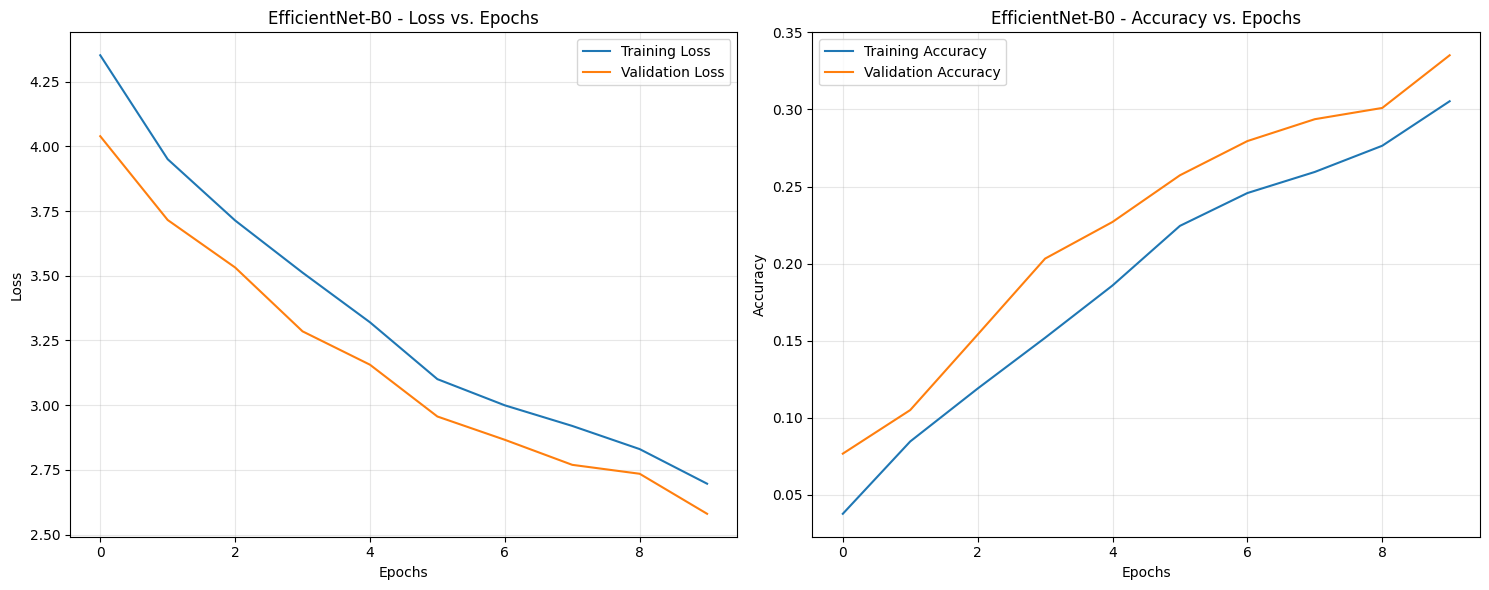


EfficientNet-B0 Metrics:
Accuracy: 0.3352
Precision: 0.3332
Recall: 0.3352
F1-Score: 0.3235
True Positives: 3352.0
False Positives: 6648.0
False Negatives: 6648.0


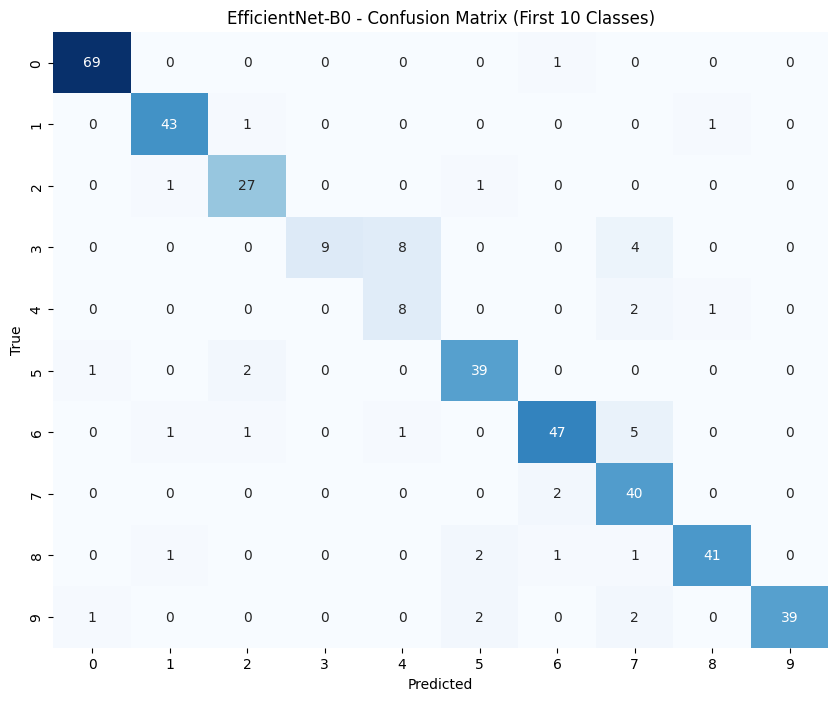

Top 5 classes by accuracy:
  Class 82: 0.8100
  Class 52: 0.8100
  Class 68: 0.7300
  Class 60: 0.7200
  Class 0: 0.6900

Bottom 5 classes by accuracy:
  Class 55: 0.0300
  Class 80: 0.0600
  Class 46: 0.0800
  Class 4: 0.0800
  Class 84: 0.0800


In [15]:
# Get standard models
standard_models = setup_standard_models()

# Train and evaluate each model
for model_name, model in standard_models.items():
    print(f"\n===== Processing {model_name} =====")

    # Define optimizer and scheduler
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

    # Train model (reduced epochs for standard models)
    model, train_losses, val_losses, train_accs, val_accs = train_model(
        model, model_name, criterion, optimizer, scheduler, num_epochs=10, early_stopping=7)

    # Plot training history
    plot_training_history(train_losses, val_losses, train_accs, val_accs, model_name)

    # Visualize filters
    # visualize_filters(model, model_name)

    # Evaluate model
    metrics = evaluate_model(model, testloader)
    results[model_name] = metrics

    # Print metrics
    print(f"\n{model_name} Metrics:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-Score: {metrics['f1_score']:.4f}")
    print(f"True Positives: {metrics['true_positives']}")
    print(f"False Positives: {metrics['false_positives']}")
    print(f"False Negatives: {metrics['false_negatives']}")

    # Plot confusion matrix
    plot_confusion_matrix(metrics['confusion_matrix'], model_name)

,Model,Accuracy,Precision,Recall,F1-Score,TP,FP,FN
0,CustomCNN,0.5600,0.5660,0.5600,0.5520,5600,4400,4400
1,ResNet-50,0.6286,0.6510,0.6286,0.6275,6286,3714,3714
2,VGG-19,0.0271,0.0021,0.0271,0.0034,271,9729,9729
3,DenseNet-121,0.5276,0.5288,0.5276,0.5208,5276,4724,4724
4,EfficientNet-B0,0.3352,0.3332,0.3352,0.3235,3352,6648,6648


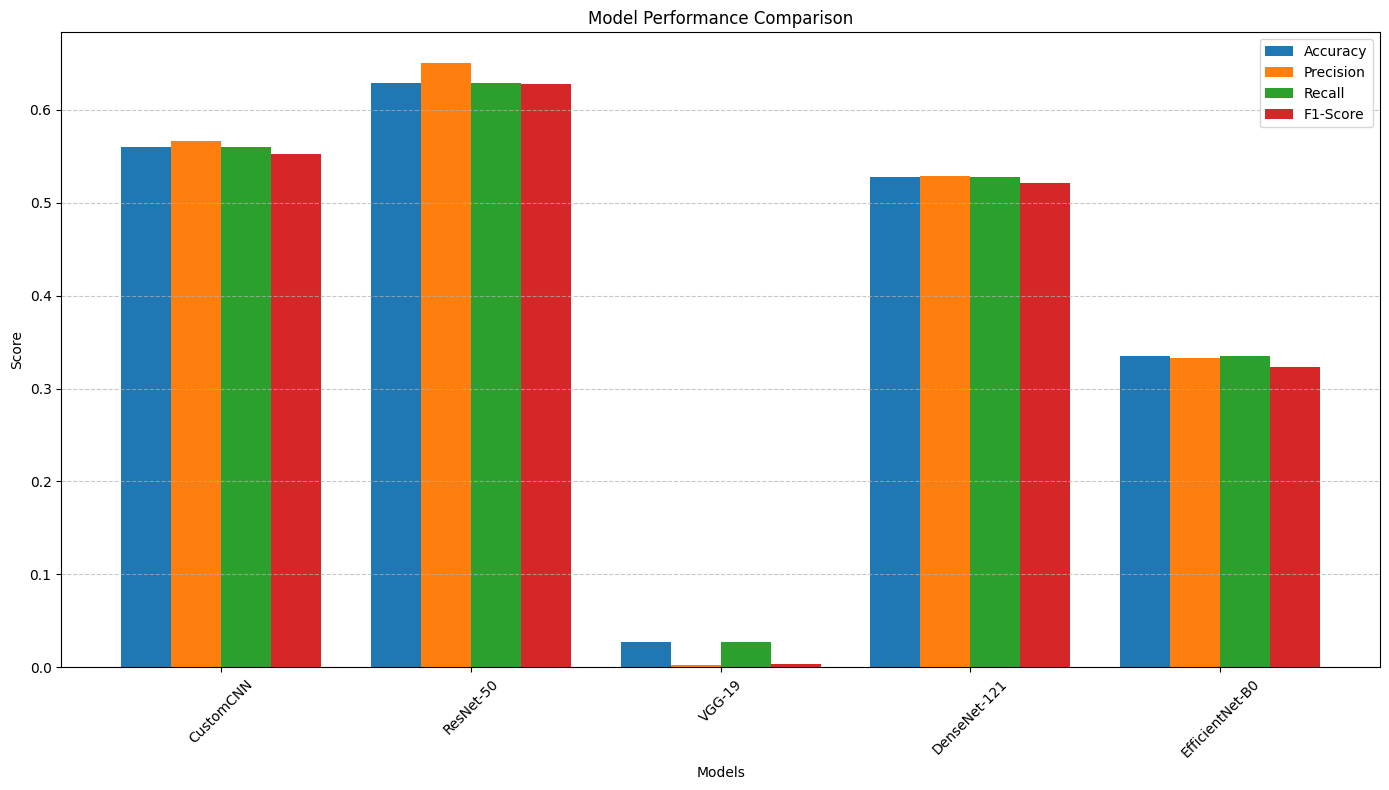

In [16]:
# Compare all models and generate visualizations
comparison_df = compare_models(results)